In [1]:
# !pip install shapely

In [2]:
import cv2
from tqdm.notebook import tqdm
from metrics import * 
from copy import deepcopy
# Usage:
# evaluate(predictions, ground_truths, findBoundingBoxs=findBoundingboxs, threshold=0.5, iou_threshold=0.5):
"""
Given predictions and ground truths, calculate AP, Precision and Recall.
:param predictions: An array of prediction images.
:param ground_truths: An array of ground truth images.
:param findBoundingBoxes: A method that takes in an image, and return 
                          its bounding boxes and their corresponding confidence scores.
:param threshold: Convert image to a binary image using this threshold.
:param iou_threshold: IOU threshold for classifying a True Positive.
:return AP, precision, recall, and calculation table of dataset.
"""
pass

In [3]:
base_dir = "/home/ec2-user/SageMaker/benchmarks/dataset/ynet/"
predictions = []
ground_truths = []
for i in tqdm(range(90000, 100000)):
    prediction_path = "prediction/predict_{}.png".format(i)
    train_mask_path = "Y/train_mask_{}.png".format(i)
    prediction = cv2.imread(base_dir + prediction_path)
    gt = cv2.imread(base_dir + train_mask_path)
    predictions.append(prediction)
    ground_truths.append(gt)

/home/ec2-user/SageMaker/benchmarks/Mask_RCNN/samples/barcode/metrics.py:74: RuntimeWarning: invalid value encountered in true_divide
  return im / im.max()
/home/ec2-user/SageMaker/benchmarks/Mask_RCNN/samples/barcode/metrics.py:93: RuntimeWarning: invalid value encountered in greater
  prediction = (normalize_to_gray(prediction) > threshold).astype(np.uint8)
/home/ec2-user/SageMaker/benchmarks/Mask_RCNN/samples/barcode/metrics.py:94: RuntimeWarning: invalid value encountered in greater
  ground_truth = (normalize_to_gray(ground_truth) > threshold).astype(np.uint8)



At IOU 80.0
AP: 0.015778588624768324
Precision: 0.142253807106599
Recall: 0.11197815060476005


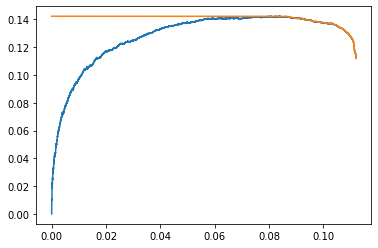

In [5]:
# example

AP, precision, recall, data = evaluate(predictions, ground_truths, 
                                       findBoundingBoxs=findBoundingboxs, threshold=0.5, iou_threshold=0.8)

At IOU 90.0
AP: 2.126053781895792e-05
Precision: 0.008064516129032258
Recall: 0.003809873539739735


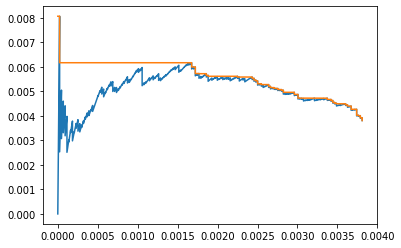

In [24]:
threshold=0.5
iou_threshold=0.9
data['total_num_GT'] = total_num_GT
data["TP"] = (data["iou"] >= iou_threshold) * 1
data["FP"] = (data["iou"] < iou_threshold) * 1
data = data.sort_values(by=["confidenceScore"], ascending=[False])
data["Acc TP"] = np.cumsum(data["TP"])
data["Acc FP"] = np.cumsum(data["FP"])
data["Precision"] = data["Acc TP"] / (data["Acc TP"] + data["Acc FP"])
data["Recall"] = data["Acc TP"] / data['total_num_GT']
plt.plot(list(data["Recall"]), list(data["Precision"]))
interpolation = list(data["Precision"])
for i in reversed(range(len(interpolation) - 1)):
    if interpolation[i+1]>interpolation[i]:
        interpolation[i]=interpolation[i+1]
plt.plot(list(data["Recall"]), interpolation)
AP = metrics.auc(list(data["Recall"]), interpolation)
precision = max(list(data["Precision"]))
recall = max(list(data["Recall"]))
print("At IOU", iou_threshold * 100)
print("AP:", AP)
print("Precision:", precision)
print("Recall:", recall)

In [22]:
import pickle
with open("synthetic_eval.pickle", "wb") as f:
    pickle.dump(data, f)

In [8]:
cv=cv2
def findBoundingboxss(image, correction_margin=0):
    #print('A')
    ##################### no trans#############################
    #contours, _ = cv.findContours(image.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    ##################### morph trans #########################
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (5, 5))
    closed = cv.morphologyEx(image, cv.MORPH_OPEN, kernel)
    closed = cv.erode(closed, None, iterations = 3)
    contours, _ = cv.findContours(closed.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    ##################### Watershed ############################
    #_, imgray = cv.threshold(closed, 0, 255, cv.THRESH_BINARY)
#     closed = image
#     #t=time.time()
#     Distance = ndimage.distance_transform_edt(closed)
#     D = ((Distance - Distance.min()) / (Distance.max() - Distance.min()) * 255).astype(np.uint8)
#     _, D = cv.threshold(D, 0, 255, cv.THRESH_BINARY)
#     localMax = peak_local_max(D, indices=False, min_distance=1, labels=closed)
#     markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
#     labels = watershed(-D, markers, mask=closed)
#     boundingBoxs = []
#     scores = []
#     for i in range(1, labels.max()+1):
#         mask_temp = np.where(labels==i, np.uint8(255), np.uint8(0))
#         contours, _ = cv.findContours(mask_temp.copy(), cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
#         for contour in contours:
#             rect = cv.minAreaRect(contour)
#             poly = cv.boxPoints(rect)
#             box = np.int0(poly)
#             boundingBoxs.append(box)
#             scores.append(get_confidence_score(image, box))
#     #print(t-time.time())
#     return boundingBoxs, scores
# comment up to watershed and uncomment bellow as it is
    #contours, _ = cv.findContours(closed.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    boundingBoxs = []
    scores = []
    for contour in contours:
        rect = cv.minAreaRect(contour)
        ############ polygone bboxes ##############
        poly = cv.boxPoints(rect)
        box = np.int0(poly)
        #boundingBoxs.append(box)
        ############ Up Right bboxes ##############
        x, y, w, h = cv.boundingRect(contour)
        temp = [y - correction_margin, x - correction_margin, y + h + correction_margin, x + w + correction_margin]
        boundingBoxs.append(temp)
        scores.append(get_confidence_score_(image, box))    
    return boundingBoxs, scores

def normalize_to_gray(im):
    if len(im.shape) > 2:
        im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
        _, im = cv.threshold(((im*255).astype(np.uint8)).copy(),0 ,255 ,cv.THRESH_OTSU+cv.THRESH_BINARY)
    im = im / im.max()
    return im 

def calc_iou_individual(pred_box, gt_box):

    x1_t, y1_t, x2_t, y2_t = gt_box
    x1_p, y1_p, x2_p, y2_p = pred_box

#     if (x1_p > x2_p) or (y1_p > y2_p):
#         raise AssertionError(
#             "Prediction box is malformed? pred box: {}".format(pred_box))
#     if (x1_t > x2_t) or (y1_t > y2_t):
#         raise AssertionError(
#             "Ground Truth box is malformed? true box: {}".format(gt_box))

    if (x2_t < x1_p or x2_p < x1_t or y2_t < y1_p or y2_p < y1_t):
        return 0.0

    far_x = np.min([x2_t, x2_p])
    near_x = np.max([x1_t, x1_p])
    far_y = np.min([y2_t, y2_p])
    near_y = np.max([y1_t, y1_p])

    inter_area = (far_x - near_x + 1) * (far_y - near_y + 1)
    true_box_area = (x2_t - x1_t + 1) * (y2_t - y1_t + 1)
    pred_box_area = (x2_p - x1_p + 1) * (y2_p - y1_p + 1)
    iou = inter_area / (true_box_area + pred_box_area - inter_area)
    return iou

def get_single_image_results(gt_boxes, pred_boxes, iou_thr):

    all_pred_indices = range(len(pred_boxes))
    all_gt_indices = range(len(gt_boxes))
    if len(all_pred_indices) == 0:
        #print('A')
        tp = 0
        fp = 0
        fn = len(gt_boxes)
        #pp.pprint({'true_pos': tp, 'false_pos': fp, 'false_neg': fn})
        return {'true_pos': tp, 'false_pos': fp, 'false_neg': fn}
    if len(all_gt_indices) == 0:
        #print('B')
        tp = 0
        fp = len(pred_boxes)
        fn = 0
        #pp.pprint({'true_pos': tp, 'false_pos': fp, 'false_neg': fn})
        return {'true_pos': tp, 'false_pos': fp, 'false_neg': fn}

    gt_idx_thr = []
    pred_idx_thr = []
    ious = []
    for ipb, pred_box in enumerate(pred_boxes):
        for igb, gt_box in enumerate(gt_boxes):
            iou = calc_iou_individual(pred_box, gt_box)
            if iou > iou_thr:
                gt_idx_thr.append(igb)
                pred_idx_thr.append(ipb)
                ious.append(iou)
            #print(iou)
    args_desc = np.argsort(ious)[::-1]
    if len(args_desc) == 0:
        #print('C')
        # No matches
        tp = 0
        fp = len(pred_boxes)
        fn = len(gt_boxes)
    else:
        #print('D')
        gt_match_idx = []
        pred_match_idx = []
        for idx in args_desc:
            gt_idx = gt_idx_thr[idx]
            pr_idx = pred_idx_thr[idx]
            # If the boxes are unmatched, add them to matches
            if (gt_idx not in gt_match_idx) and (pr_idx not in pred_match_idx):
                gt_match_idx.append(gt_idx)
                pred_match_idx.append(pr_idx)
        tp = len(gt_match_idx)
        fp = len(pred_boxes) - len(pred_match_idx)
        fn = len(gt_boxes) - len(gt_match_idx)
    #pp.pprint({'true_pos': tp, 'false_pos': fp, 'false_neg': fn})
    return {'true_pos': tp, 'false_pos': fp, 'false_neg': fn}


def get_confidence_score_(im_mask, bb):
    cnt = 0
    pixel_acc = 0
    im_w = im_mask.shape[0]
    im_h = im_mask.shape[1]
    poly = Polygon(bb)
    minx, miny, maxx, maxy = list(np.int_(poly.bounds))
    for row in range(minx, min( 400, maxx)):
        for col in range(miny, min(400, maxy)):
            p_temp = Point(row, col)
            if p_temp.within(poly):
                cnt += 1
                pixel_acc = pixel_acc + im_mask[col, row]#/im_mask.max()
    if cnt == 0:
        return 0
    avg_pix_value = pixel_acc/cnt
    return avg_pix_value

In [9]:
def result_dict_pred(predictions, findBoundingBoxss=findBoundingboxss,  threshold=0.5, correction_margin=0):
    k = 0
    pred_boxs = {}
    for prediction in tqdm(predictions):
        if prediction is None:
            k+=1
            continue
        prediction = (normalize_to_gray(prediction) > threshold).astype(np.uint8)
        bbs_pred, confidences = findBoundingBoxss(prediction, correction_margin)
        # Pred Boxes dict
        pred_boxs["img_{:d}".format(k)]= {"boxes": bbs_pred, "scores": confidences}
        k+=1
    return pred_boxs

def gt_extract(gt_dict):
    gt_ex = {}
    for key in gt_dict:
        gt_dict[key] = gt_dict[key]['boxes']
    return gt_ex


In [10]:
pred_boxes_dict = result_dict_pred(predictions, 
                                   findBoundingBoxss=findBoundingboxss, threshold=0.5, correction_margin=4)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:55: RuntimeWarning: invalid value encountered in true_divide
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater


In [11]:
gt_boxes_dict = result_dict_pred(ground_truths,
                                   findBoundingBoxss=findBoundingboxss, threshold=0.5, correction_margin=4)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:55: RuntimeWarning: invalid value encountered in true_divide
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater


In [12]:
copy_gt = gt_extract(gt_boxes_dict)

In [13]:
def get_model_scores_map(pred_boxes):

    model_scores_map = {}
    for img_id, val in pred_boxes.items():
        for score in val['scores']:
            if score not in model_scores_map.keys():
                model_scores_map[score] = [img_id]
            else:
                model_scores_map[score].append(img_id)
    return model_scores_map

def get_avg_precision_at_iou3(gt_boxes, pred_boxes, iou_thr=0.5):

    model_scores_map = get_model_scores_map(pred_boxes)
    sorted_model_scores = sorted(model_scores_map.keys())

    # Sort the predicted boxes in descending order (lowest scoring boxes first):
    for img_id in pred_boxes.keys():
        arg_sort = np.argsort(pred_boxes[img_id]['scores'])
        pred_boxes[img_id]['scores'] = np.array(pred_boxes[img_id]['scores'])[arg_sort].tolist()
        pred_boxes[img_id]['boxes'] = np.array(pred_boxes[img_id]['boxes'])[arg_sort].tolist()

    pred_boxes_pruned = deepcopy(pred_boxes)

    precisions = []
    recalls = []
    model_thrs = []
    img_results = {}
    # Loop over model score thresholds and calculate precision, recall
    for ithr, model_score_thr in tqdm(enumerate(sorted_model_scores[:-1]), total=len(sorted_model_scores)):
        # On first iteration, define img_results for the first time:
        img_ids = gt_boxes.keys() if ithr == 0 else model_scores_map[model_score_thr]
        for img_id in img_ids:
            gt_boxes_img = gt_boxes[img_id]
            if img_id in pred_boxes_pruned:
                box_scores = pred_boxes_pruned[img_id]['scores']
            else:
                box_scores = []
                pred_boxes_pruned[img_id] = {}
                pred_boxes_pruned[img_id]['scores'] = []
                pred_boxes_pruned[img_id]['boxes'] = []
            start_idx = 0
            for score in box_scores:
                if score <= model_score_thr:
                    pred_boxes_pruned[img_id]
                    start_idx += 1
                else:
                    break

            # Remove boxes, scores of lower than threshold scores:
            pred_boxes_pruned[img_id]['scores'] = pred_boxes_pruned[img_id]['scores'][start_idx:]
            pred_boxes_pruned[img_id]['boxes'] = pred_boxes_pruned[img_id]['boxes'][start_idx:]

            # Recalculate image results for this image
            img_results[img_id] = get_single_image_results(
                gt_boxes_img, pred_boxes_pruned[img_id]['boxes'], iou_thr)

        prec, rec = calc_precision_recall(img_results)
        precisions.append(prec)
        recalls.append(rec)
        model_thrs.append(model_score_thr)

    precisions = np.array(precisions)
    recalls = np.array(recalls)
    prec_at_rec = []
    for recall_level in np.linspace(0.0, 1.0, 11):
        try:
            args = np.argwhere(recalls >= recall_level).flatten()
            prec = max(precisions[args])
        except ValueError:
            prec = 0.0
        prec_at_rec.append(prec)
    avg_prec = np.mean(prec_at_rec)

    return {
        'avg_prec': avg_prec,
        'precisions': precisions,
        'recalls': recalls,
        'model_thrs': model_thrs}

def calc_precision_recall(img_results):

    true_pos = 0; false_pos = 0; false_neg = 0
    for _, res in img_results.items():
        true_pos += res['true_pos']
        false_pos += res['false_pos']
        false_neg += res['false_neg']

    try:
        precision = true_pos/(true_pos + false_pos)
    except ZeroDivisionError:
        precision = 0.0
    try:
        recall = true_pos/(true_pos + false_neg)
    except ZeroDivisionError:
        recall = 0.0

    return (precision, recall)

In [14]:
results = get_avg_precision_at_iou3(gt_boxes_dict, pred_boxes_dict, iou_thr=0.5)
ap = results['avg_prec']
p = results['precisions']
r = results ['recalls']

print('AP = ', ap)
print('prec = ', p[-1])
print('rec = ', r[-1])


AP =  0.5994036277517627
prec =  0.5766709366287394
rec =  0.16264983422596277


In [31]:
results = get_avg_precision_at_iou3(gt_boxes_dict, pred_boxes_dict, iou_thr=0.9)
ap = results['avg_prec']
p = results['precisions']
r = results ['recalls']

print('AP = ', ap)
print('prec = ', p[-1])
print('rec = ', r[-1])


AP =  0.004076267802475709
prec =  0.013337352121166454
rec =  0.0037617954603417496


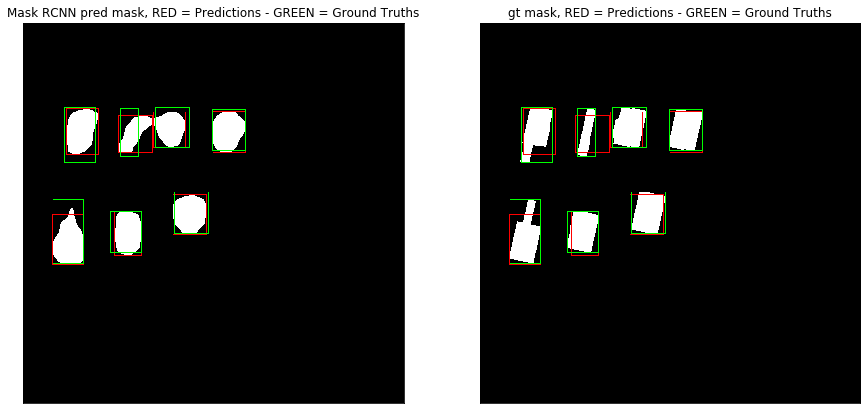

In [30]:
# visual check 
target_image_idx = 367#np.random.randint(start_idx, end_idx)
#pp.pprint(pred_boxes_dict['img_{:d}'.format(target_image_idx)])
pred_bboxes_coord = pred_boxes_dict['img_{:d}'.format(target_image_idx)]['boxes']
pred_bboxes_scores = pred_boxes_dict['img_{:d}'.format(target_image_idx)]['scores']
gt_bboxes_coord = gt_boxes_dict['img_{:d}'.format(target_image_idx)]

xx = (np.squeeze(ground_truths[target_image_idx]*255).astype(np.uint8)).copy()
# xx = cv.cvtColor(xx, cv.COLOR_GRAY2RGB)
xx_pred = (np.squeeze(predictions[target_image_idx]*255).astype(np.uint8)).copy()
# xx_pred = cv.cvtColor(xx_pred, cv.COLOR_GRAY2RGB)
for bbox_pred in pred_bboxes_coord:
    cv.rectangle(xx, (bbox_pred[1], bbox_pred[0], bbox_pred[3]-bbox_pred[1], bbox_pred[2]-bbox_pred[0]), (255, 0, 0), 1)
    cv.rectangle(xx_pred, (bbox_pred[1], bbox_pred[0], bbox_pred[3]-bbox_pred[1], bbox_pred[2]-bbox_pred[0]), (255, 0, 0), 1)
for bbox_gt in gt_bboxes_coord:
    cv.rectangle(xx, (bbox_gt[1], bbox_gt[0], bbox_gt[3]-bbox_gt[1], bbox_gt[2]-bbox_gt[0]), (0, 255, 0), 1)
    cv.rectangle(xx_pred, (bbox_gt[1], bbox_gt[0], bbox_gt[3]-bbox_gt[1], bbox_gt[2]-bbox_gt[0]), (0, 255, 0), 1)
    
show_images2(xx_pred, 
             xx, 
             title1='Mask RCNN pred mask, RED = Predictions - GREEN = Ground Truths', 
             title2 = 'gt mask, RED = Predictions - GREEN = Ground Truths')


In [18]:
def show_images2 (Im1, Im2, title1="", title2 = ""):
    display_window_edge_size = 15
    width = display_window_edge_size
    height = display_window_edge_size
    fig = plt.figure(figsize=[width,height])
    axis1 = fig.add_subplot(121)
    axis1.imshow(Im1, cmap="gray")
    axis1.set(xticks=[],yticks=[],title =title1)

    axis2 = fig.add_subplot(122)
    axis2.imshow(Im2, cmap="gray")
    axis2.set(xticks=[],yticks=[],title =title2)

In [38]:
im = predictions[0]

In [64]:
total_pixels = 0
correct = 0
for i in tqdm(range(len(predictions))):
    if (predictions[i] is None) or ground_truths[i] is None:
        continue
    pred = normalize_to_gray(predictions[i])
    gt = normalize_to_gray(ground_truths[i])
    
    diff = np.abs(pred - gt)
    total_pixels += 400*400
    correct += len(diff[np.where(diff < 0.5)])
    


                
    

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:55: RuntimeWarning: invalid value encountered in true_divide
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in less


In [39]:
im = normalize_to_gray(im)

In [65]:
correct / total_pixels

0.9221246708451593

In [63]:
len(diff[np.where(diff < 0.5)])

158267

In [60]:
diff.shape

(400, 400)